In [1]:
import os
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
def get_team_stats(stats_filter=None, datasets_dir=None, stats_file_name=None):
    """
    Combine game data and regular season statistics to form a DataFrame where each row represents one game from an NCAA
    tournament. Ensure the Team1 and Team2 values are randomly swapped in games_file_name so that the first team is not
    always the higher seed. (Done already for provided data).
    :param stats_filter: A function to filter which statistics are kept. Takes a list of stat names and should return
        the filtered list. If None, keep all stats. Defaults to None.
    :param datasets_dir: Name of the directory in cwd containing the CSVs with games_file and stats_file. Defaults to
        'datasets'.
    :param stats_file_name: Name of the CSV file containing regular season statistics for each team.
    :return: pandas DataFrame containing team statistics from the year 2010-2018, as well as their seeding position
        within the NCAA tournament
    """
    datasets_dir = 'datasets' if datasets_dir is None else datasets_dir
    stats_file_name = 'Stats by team and year 2010-2018.csv' if stats_file_name is None else stats_file_name
    if stats_file_name[-4:] != '.csv':
        raise Warning('stats_file_name must end in .csv. A CSV file is required.')
    stats_file_path = os.path.join(datasets_dir, stats_file_name)

    df_stats = pd.read_csv(stats_file_path, sep=',')
    df_stats = df_stats.loc[:, ~df_stats.columns.str.contains('^Unnamed')]
    if stats_filter is not None:
        stats = list(df_stats.columns.drop(['School ID', 'Year']))
        stats = stats_filter(stats)
        stats.insert(0, 'School ID')
        df_stats = df_stats[stats]

    for i in range(0,len(df_stats['School ID'])):
        df_stats.iloc[i,0] = df_stats.iloc[i,0][:-5]

    return df_stats

In [3]:
# The first step is getting all the data from Team Stats in a Pandas DataFrame
team_data = get_team_stats(stats_filter=None, datasets_dir=None, stats_file_name=None)

In [4]:
# However, for unsupervised learning, we are attempting to predict tournament seeding based on the team stats for that year
# We need to isolate the stats for the year 2018
team_data_2018 = team_data.loc[team_data['Year']==2018]
team_data_2018 = team_data_2018.sort_values(by=['Seed'])

#Put the qualified teams on top and reset the indices of 
qualified_teams = team_data_2018.loc[team_data_2018['Seed']>0]
disqualified_teams = team_data_2018.loc[team_data_2018['Seed']==0]
team_data_2018 = pd.concat([qualified_teams,disqualified_teams],axis=0)
team_data_2018 = team_data_2018.reset_index(drop=True)

print('The number of teams that did not qualify were {}'.format(team_data_2018['Seed'].value_counts()[0]))

The number of teams that did not qualify were 287


In [5]:
#Furthermore, one of the columns is the seeding position in the tournament, which we could consider a ground truth
#This statistics should not be included into the algorithm because it doesn't inform team performance prior to the tournament
seed_label = qualified_teams.loc[:,['School ID','Seed']]
seed_label = seed_label.reset_index(drop=True)
team_data_2018.pop('Seed')
team_data_2018.pop('Seed Norm')
print('Eliminated Seed and Seed Norm Columns')

Eliminated Seed and Seed Norm Columns


In [6]:
print('The number of features in the data (excluding School ID and Year) is {}'.format(len(team_data_2018.columns)-2))
print('The number of features in the data (excluding School ID and Year and normalized data) is 15')

The number of features in the data (excluding School ID and Year) is 28
The number of features in the data (excluding School ID and Year and normalized data) is 15


Without removing the normalized columns in the data, the first 3 principal components explain 77.18% of the variance
Over 95% of the variance would be captured by using the first 7 principal components


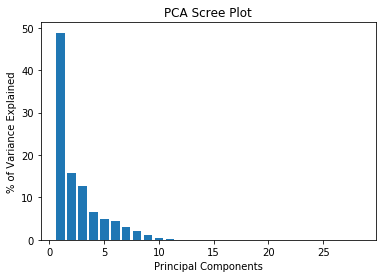

In [7]:
pca_all = PCA(n_components=28)

mean_all = np.mean(team_data_2018.iloc[:,2:])
stdev_all = np.std(team_data_2018.iloc[:,2:])
principalComponents = pca_all.fit_transform((team_data_2018.iloc[:,2:]-mean_all)/stdev_all)

percent_variance = np.round(pca_all.explained_variance_ratio_* 100, decimals =2)
plt.bar(x= range(1,29), height=percent_variance)
plt.ylabel('% of Variance Explained')
plt.xlabel('Principal Components')
plt.title('PCA Scree Plot')

print('Without removing the normalized columns in the data, the first 3 principal components explain {}% of the variance'.format(np.sum(percent_variance[0:3])))

cum_sum = 0
for i in range(0,len(percent_variance)):
    cum_sum += percent_variance[i]
    if cum_sum > 95:
        j = i + 1
        break
        
print('Over 95% of the variance would be captured by using the first {} principal components'.format(j))

After removing the normalized columns in the data, the first 3 principal components explain 77.18% of the variance
It is the same since normalized data is a linear combination of other features. We will use these PCs from now on
Over 95% of the variance would be captured by using the first 7 principal components


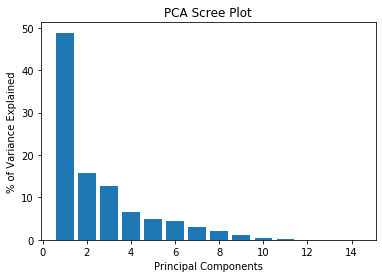

In [8]:
pca_processed = PCA(n_components=14)

mean_processed = np.mean(team_data_2018.iloc[:,2:16])
stdev_processed = np.std(team_data_2018.iloc[:,2:16])
principalComponents = pca_processed.fit_transform((team_data_2018.iloc[:,2:16]-mean_processed)/stdev_processed)

team_stats_2018_all = pd.concat([team_data_2018.iloc[:,0:2],
                                pd.DataFrame(data = principalComponents,
                                             columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14'])],axis=1)
qualified_stats_2018_all = team_stats_2018_all.head(64)
unqualified_stats_2018_all = team_stats_2018_all.tail(287)

percent_variance = np.round(pca_processed.explained_variance_ratio_* 100, decimals =2)
plt.bar(x= range(1,15), height=percent_variance)
plt.ylabel('% of Variance Explained')
plt.xlabel('Principal Components')
plt.title('PCA Scree Plot')

print('After removing the normalized columns in the data, the first 3 principal components explain {}% of the variance'.format(np.sum(percent_variance[0:3])))
print('It is the same since normalized data is a linear combination of other features. We will use these PCs from now on')

cum_sum = 0
for i in range(0,len(percent_variance)):
    cum_sum += percent_variance[i]
    if cum_sum > 95:
        j = i + 1
        break
        
print('Over 95% of the variance would be captured by using the first {} principal components'.format(j))

#### There is really no need to create a PCA with 3 Principal Components since we can just grab them from above

It seems like projecting the stats of qualified teams onto the first 3 PCs does not yield a good division


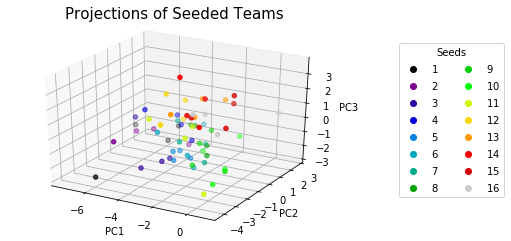

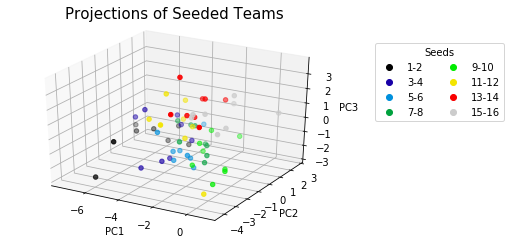

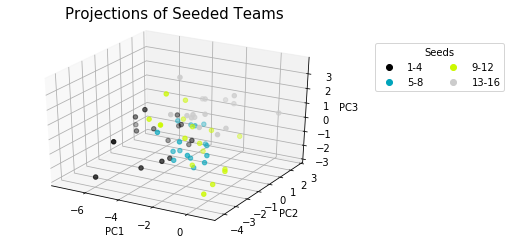

In [10]:
pc1 = qualified_stats_2018_all['PC1']
pc2 = qualified_stats_2018_all['PC2']
pc3 = qualified_stats_2018_all['PC3']

#All Seeds (1-16)
fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=seed_label.iloc[:,1],cmap='nipy_spectral')
ax.set_title('Projections of Seeded Teams',fontsize = 15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend = plt.legend(*scatter_3D.legend_elements(num=16), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

#Seeds (1-8)
fig2 = plt.figure()
ax = fig2.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=(np.arange(8*8) // 8)+1,cmap='nipy_spectral')
ax.set_title('Projections of Seeded Teams',fontsize = 15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
handles, labels = scatter_3D.legend_elements()
legend = plt.legend(handles,('1-2','3-4','5-6','7-8','9-10','11-12','13-14','15-16'), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

#Seeds (1-4)
fig3 = plt.figure()
ax = fig3.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=(np.arange(4*16) // 16)+1,cmap='nipy_spectral')
ax.set_title('Projections of Seeded Teams',fontsize = 15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
handles, labels = scatter_3D.legend_elements()
legend = plt.legend(handles,('1-4','5-8','9-12','13-16'), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

print('It seems like projecting the stats of qualified teams onto the first 3 PCs does not yield a good division')

In two dimensions is easier to capture the poor correlation of statistics to Seed number


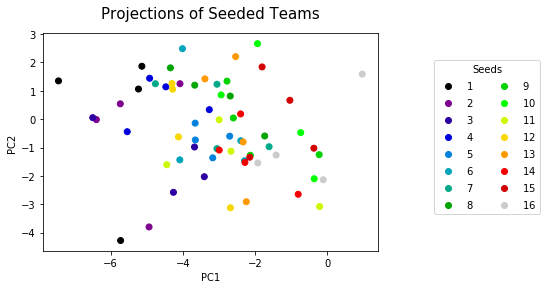

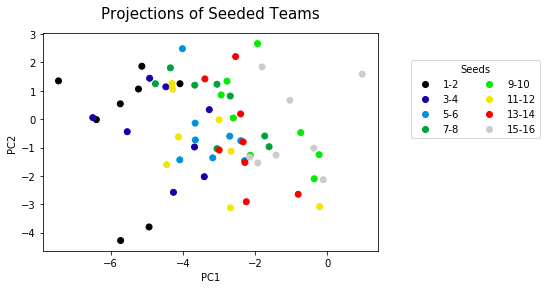

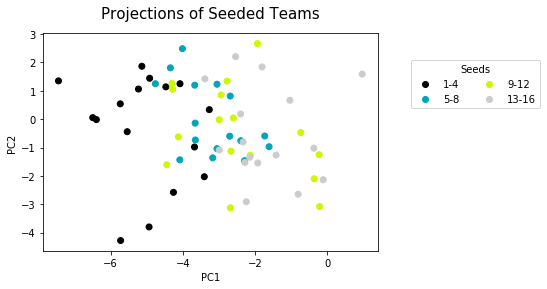

In [11]:
#All Seeds (1-16)
fig1 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=seed_label.iloc[:,1],cmap='nipy_spectral')
plt.title('Projections of Seeded Teams',fontsize = 15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
legend = plt.legend(*scatter_2D.legend_elements(num=16), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

#Seeds (1-8)
fig2 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=(np.arange(8*8) // 8)+1,cmap='nipy_spectral')
plt.title('Projections of Seeded Teams',fontsize = 15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
handles, labels = scatter_2D.legend_elements()
legend = plt.legend(handles,('1-2','3-4','5-6','7-8','9-10','11-12','13-14','15-16'), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

#Seeds (1-4)
fig3 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=(np.arange(4*16) // 16)+1,cmap='nipy_spectral')
plt.title('Projections of Seeded Teams',fontsize = 15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
handles, labels = scatter_2D.legend_elements()
legend = plt.legend(handles,('1-4','5-8','9-12','13-16'), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

print('In two dimensions is easier to capture the poor correlation of statistics to Seed number')

However there is a stark contrast between qualified and unqualified teams, where qualified teams are further left on PC1


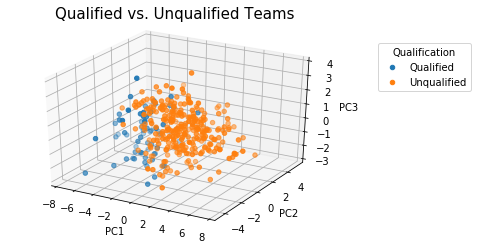

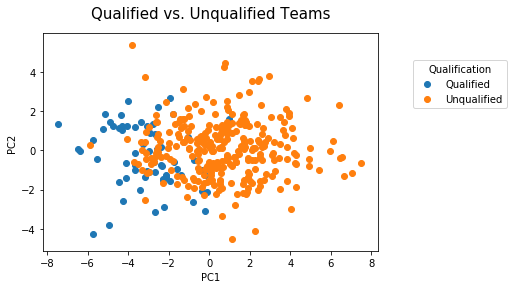

In [12]:
pc1_qualified = qualified_stats_2018_all['PC1']
pc2_qualified = qualified_stats_2018_all['PC2']
pc3_qualified = qualified_stats_2018_all['PC3']

pc1_unqualified = unqualified_stats_2018_all['PC1']
pc2_unqualified = unqualified_stats_2018_all['PC2']
pc3_unqualified = unqualified_stats_2018_all['PC3']

pc1_all = pd.concat([pc1_qualified,pc1_unqualified])
pc2_all = pd.concat([pc2_qualified,pc2_unqualified])
pc3_all = pd.concat([pc3_qualified,pc3_unqualified])

#3D-plot
fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
ax.scatter(pc1_qualified,pc2_qualified,pc3_qualified)
ax.scatter(pc1_unqualified,pc2_unqualified,pc3_unqualified)
ax.set_title('Qualified vs. Unqualified Teams',fontsize = 15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(['Qualified','Unqualified'],title='Qualification',bbox_to_anchor=(1.4,0.9))

#2D-plot
fig2 = plt.figure()
plt.scatter(pc1_qualified,pc2_qualified)
plt.scatter(pc1_unqualified,pc2_unqualified)
plt.title('Qualified vs. Unqualified Teams',fontsize = 15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Qualified','Unqualified'],title='Qualification',bbox_to_anchor=(1.4,0.9))

print('However there is a stark contrast between qualified and unqualified teams, where qualified teams are further left on PC1')

## How can we use K-Means?

I can see two options here:

**1)** We can use a modified K-Means algorith on the transformed 2018 data in which we limit the number of points per cluster to a specified amount we want (depending on seeding 1,...,8 or 1-2, ..., 7-8, or 1-4,5-8). Furthermore, we can evaluate the clustering with methods taught in class against the ground truth that we know (explicit methods). The only concern I have is how to determine which cluster is which, i.e. how do I say this group is cluster 1 corresponding to Seed 1-4. That's the job of unsupervised learning

**2)** We can use regular K-Means on the data for all years instead of 2018, trying to separate qualified teams vs. unqualified (We can do this simply with PCA). Furthermore, I expect it to not be great given the symmetry of the data... Different cluster initialization will give me different results along a different axis of symmetry

## First Method

In [13]:
from sklearn.cluster import KMeans

The Regular K-Means algorithm assigns cluster number arbitrarily and doesn't limit number of points
Cluster Number and Number of Ocurrences:
1     1
2     5
3     5
4     5
5     5
6     3
7     4
8     5
9     5
10    4
11    7
12    3
13    5
14    4
15    1
16    2
Name: Cluster Number, dtype: int64


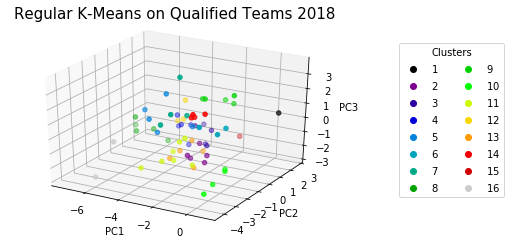

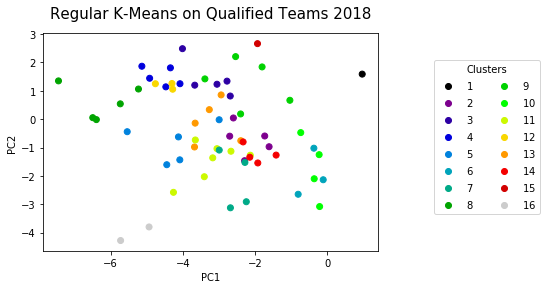

In [33]:
#All Seeds (1-16) Run 100 iterations
kmeans = KMeans(n_clusters=16,n_init=100)
predicted_regular_16 = kmeans.fit_predict(qualified_stats_2018_all.iloc[:,2:])

#3D-plot
fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=predicted_regular_16+1,cmap='nipy_spectral')    
ax.set_title('Regular K-Means on Qualified Teams 2018',fontsize=15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend = ax.legend(*scatter_3D.legend_elements(num=16), title="Clusters",bbox_to_anchor=(1.5,0.9),ncol=2)

#2D-plot
fig2 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=predicted_regular_16+1,cmap='nipy_spectral')    
plt.title('Regular K-Means on Qualified Teams 2018',fontsize=15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
legend = plt.legend(*scatter_2D.legend_elements(num=16), title="Clusters",bbox_to_anchor=(1.5,0.9),ncol=2)

cluster_results = pd.concat([qualified_stats_2018_all.iloc[:,0], pd.DataFrame(data = predicted_regular_16+1,columns = ['Cluster Number'])],axis=1)
print("The Regular K-Means algorithm assigns cluster number arbitrarily and doesn't limit number of points")
print("Cluster Number and Number of Ocurrences:")
print(cluster_results['Cluster Number'].value_counts(sort=False))

The Regular K-Means algorithm assigns cluster number arbitrarily and doesn't limit number of points
Cluster Number and Number of Ocurrences:
1     3
2     6
3     8
4     8
5    10
6     6
7    10
8    13
Name: Cluster Number, dtype: int64


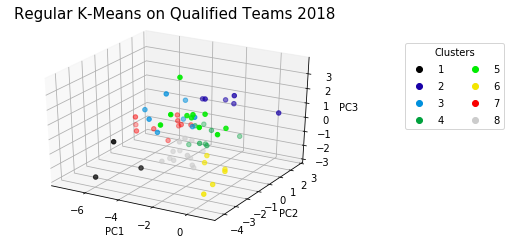

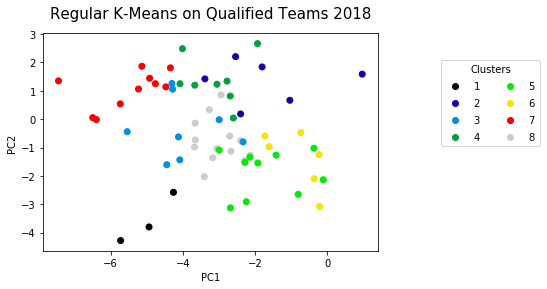

In [34]:
#Seeds (1-8) Run 100 iterations
kmeans = KMeans(n_clusters=8,n_init=100)
predicted_regular_8 = kmeans.fit_predict(qualified_stats_2018_all.iloc[:,2:])

#3D-plot
fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=predicted_regular_8+1,cmap='nipy_spectral')    
ax.set_title('Regular K-Means on Qualified Teams 2018',fontsize=15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend = ax.legend(*scatter_3D.legend_elements(num=8), title="Clusters",bbox_to_anchor=(1.5,0.9),ncol=2)

#2D-plot
fig2 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=predicted_regular_8+1,cmap='nipy_spectral')    
plt.title('Regular K-Means on Qualified Teams 2018',fontsize=15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
legend = plt.legend(*scatter_2D.legend_elements(num=8), title="Clusters",bbox_to_anchor=(1.5,0.9),ncol=2)

cluster_results = pd.concat([qualified_stats_2018_all.iloc[:,0], pd.DataFrame(data = predicted_regular_8+1,columns = ['Cluster Number'])],axis=1)
print("The Regular K-Means algorithm assigns cluster number arbitrarily and doesn't limit number of points")
print("Cluster Number and Number of Ocurrences:") #Think about doing another dataframe?
print(cluster_results['Cluster Number'].value_counts(sort=False))

The Regular K-Means algorithm assigns cluster number arbitrarily and doesn't limit number of points
Cluster Number and Number of Ocurrences:
1    24
2     8
3    15
4    17
Name: Cluster Number, dtype: int64


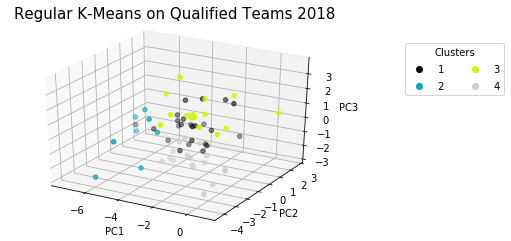

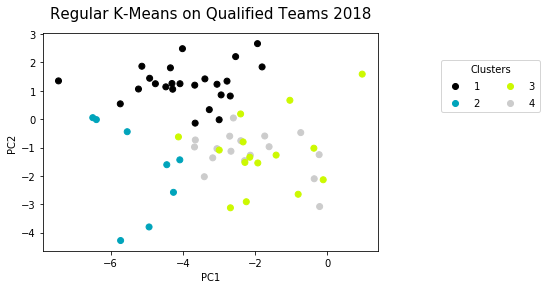

In [35]:
#Seeds (1-4) Run 100 iterations
kmeans = KMeans(n_clusters=4,n_init=100)
predicted_regular_4 = kmeans.fit_predict(qualified_stats_2018_all.iloc[:,2:])

#3D-plot
fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=predicted_regular_4+1,cmap='nipy_spectral')    
ax.set_title('Regular K-Means on Qualified Teams 2018',fontsize=15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend = ax.legend(*scatter_3D.legend_elements(), title="Clusters",bbox_to_anchor=(1.5,0.9),ncol=2)

#2D-plot
fig2 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=predicted_regular_4+1,cmap='nipy_spectral')    
plt.title('Regular K-Means on Qualified Teams 2018',fontsize=15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
legend = plt.legend(*scatter_2D.legend_elements(), title="Clusters",bbox_to_anchor=(1.5,0.9),ncol=2)

cluster_results = pd.concat([qualified_stats_2018_all.iloc[:,0], pd.DataFrame(data = predicted_regular_4+1,columns = ['Cluster Number'])],axis=1)
print("The Regular K-Means algorithm assigns cluster number arbitrarily and doesn't limit number of points")
print("Cluster Number and Number of Ocurrences:") #Think about doing another dataframe?
print(cluster_results['Cluster Number'].value_counts(sort=False))

The Regular K-Means algorithm assigns cluster number arbitrarily and doesn't limit number of points
Cluster Number and Number of Ocurrences:
1    203
2    148
Name: Cluster Number, dtype: int64


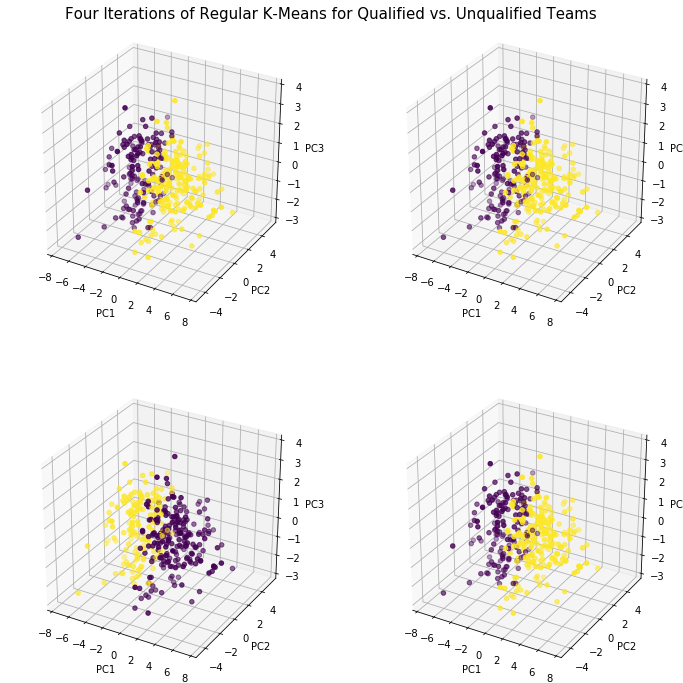

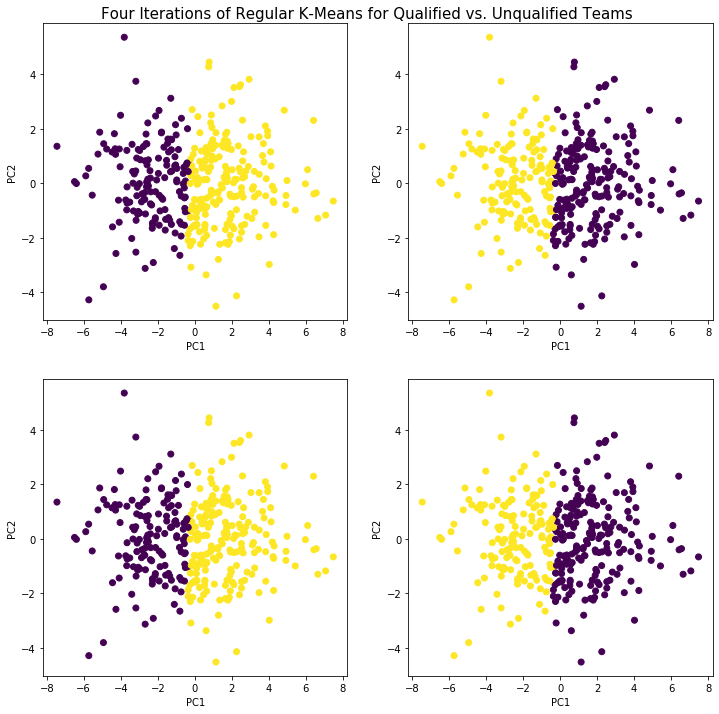

In [17]:
#All Seeds (1-16) Run 100 iterations
kmeans = KMeans(n_clusters=2,n_init=100)

#3D-plot
fig1 = plt.figure(figsize=(12,12))
fig1.suptitle('Four Iterations of Regular K-Means for Qualified vs. Unqualified Teams',fontsize=15,y=0.9)
for i in range(1,5):
    cluster_results = kmeans.fit_predict(team_stats_2018_all.iloc[:,2:])
    ax = fig1.add_subplot(2,2,i,projection='3d')
    scatter_3D = ax.scatter(pc1_all,pc2_all,pc3_all,c=cluster_results+1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

#2D-plot
fig2 = plt.figure(figsize=(12,12))
fig2.suptitle('Four Iterations of Regular K-Means for Qualified vs. Unqualified Teams',fontsize=15,y=0.9)
for i in range(1,5):
    cluster_results = kmeans.fit_predict(team_stats_2018_all.iloc[:,2:])
    ax = fig2.add_subplot(2,2,i)
    scatter_2D = ax.scatter(pc1_all,pc2_all,c=cluster_results+1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

cluster_results = pd.concat([qualified_stats_2018_all.iloc[:,0], pd.DataFrame(data = cluster_results+1,columns = ['Cluster Number'])],axis=1)
print("The Regular K-Means algorithm assigns cluster number arbitrarily and doesn't limit number of points")
print("Cluster Number and Number of Ocurrences:") #Think about doing another dataframe?
print(cluster_results['Cluster Number'].value_counts(sort=False))

## Second Method

In [18]:
def pairwise_dist(x, y):
    """
    Args:
        x: N x D numpy array
        y: M x D numpy array
    Return:
        dist: N x M array, where dist2[i, j] is the euclidean distance between 
        x[i, :] and y[j, :]
    """

    P = np.add.outer(np.sum(x**2, axis=1), np.sum(y**2, axis=1))
    N = np.dot(x, y.T)
    dist = np.sqrt(P - 2*N)
    return dist

In [19]:
def init_centers(points, K, **kwargs):
    """
    Args:
        points: NxD numpy array, where N is # points and D is the dimensionality
        K: number of clusters
        kwargs: any additional arguments you want
    Return:
        centers: K x D numpy array, the centers. 
    """
    size = np.shape(points)
    centers = np.zeros((K,size[1]))
    
    for i in range(0,K):
        number = np.random.randint(0,size[0]/K -1)
        index = int(np.around((size[0]/K)*i+number))
        centers[i,:] = points.iloc[index,:]
    
    return centers

def update_assignment(centers, points,K):
    """
    Args:
        centers: KxD numpy array, where K is the number of clusters, and D is the dimension
        points: NxD numpy array, the observations
    Return:
        cluster_idx: numpy array of length N, the cluster assignment for each point
        
    Hint: You could call pairwise_dist() function.
    """
    
    dist = pairwise_dist(centers, points)
    cluster_idx = K*np.ones(dist.shape[1],dtype=np.int8)
    i = 0
    while i < dist.shape[1]:
        index = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
        if np.count_nonzero(index[0]==cluster_idx) >= dist.shape[1]/K:
            dist[index] = 1000
        else:
            cluster_idx[index[1]] = index[0]
            dist[:,index[1]] = 1000
            i += 1
    
    return cluster_idx

def update_centers(old_centers, cluster_idx, points):
    """
    Args:
        old_centers: old centers KxD numpy array, where K is the number of clusters, and D is the dimension
        cluster_idx: numpy array of length N, the cluster assignment for each point
        points: NxD numpy array, the observations
    Return:
        centers: new centers, K x D numpy array, where K is the number of clusters, and D is the dimension.
    """
    cluster_dimensions = np.shape(old_centers)
    point_dimensions = np.shape(points)
    
    centers = np.zeros(cluster_dimensions)
    
    for i in range(0,cluster_dimensions[0]):
        which_cluster = cluster_idx==i
        which_cluster = np.reshape(which_cluster,(64,1))
        
        centers[i,:] = np.sum((which_cluster)*points,axis=0)/np.count_nonzero(which_cluster)
    
    return centers

def get_loss(centers, cluster_idx, points):
    """
    Args:
        centers: KxD numpy array, where K is the number of clusters, and D is the dimension
        cluster_idx: numpy array of length N, the cluster assignment for each point
        points: NxD numpy array, the observations
    Return:
        loss: a single float number, which is the objective function of KMeans. 
    """
    assigned_clusters = centers[cluster_idx]
    loss = np.sum(np.sqrt(np.sum((assigned_clusters - points)**2,axis=1)))
    
    return loss
        
def K_means(points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, verbose=False, **kwargs):
    """
    Args:
        points: NxD numpy array, where N is # points and D is the dimensionality
        overall_rating: numpy array of length N x 1, the rating for each point
        K: number of clusters
        max_iters: maximum number of iterations (Hint: You could change it when debugging)
        abs_tol: convergence criteria w.r.t absolute change of loss
        rel_tol: convergence criteria w.r.t relative change of loss
        verbose: boolean to set whether method should print loss (Hint: helpful for debugging)
        kwargs: any additional arguments you want
    Return:
        cluster_idx: Nx1 int numpy array, the cluster assignment for each point
    """
    centers = init_centers(points, K)
    for it in range(max_iters):
        cluster_idx = update_assignment(centers, points,K)
        centers = update_centers(centers, cluster_idx, points)
        loss = get_loss(centers, cluster_idx, points)
        K = centers.shape[0]
        if it:
            diff = np.abs(prev_loss - loss)
            if diff < abs_tol and diff / prev_loss < rel_tol:
                break
        prev_loss = loss
        if verbose:
            print('iter %d, loss: %.4f' % (it, loss))
    return cluster_idx

C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


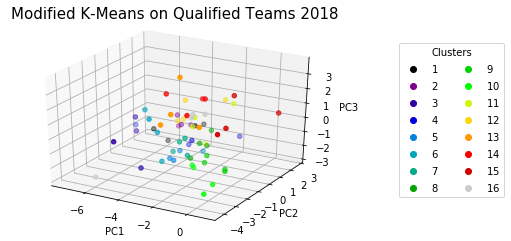

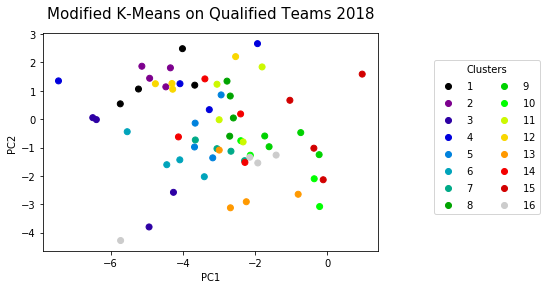

In [39]:
#16 Seeds
predicted_modified_16 =  K_means(qualified_stats_2018_all.iloc[:,2:], 16)

fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=predicted_modified_16+1,cmap='nipy_spectral')    
ax.set_title('Modified K-Means on Qualified Teams 2018',fontsize=15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend = ax.legend(*scatter_3D.legend_elements(num=16), title="Clusters",bbox_to_anchor=(1.5,0.9),ncol=2)

#2D-plot
fig2 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=predicted_modified_16+1,cmap='nipy_spectral')    
plt.title('Modified K-Means on Qualified Teams 2018',fontsize=15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
legend = plt.legend(*scatter_2D.legend_elements(num=16), title="Clusters",bbox_to_anchor=(1.5,0.9),ncol=2)

C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


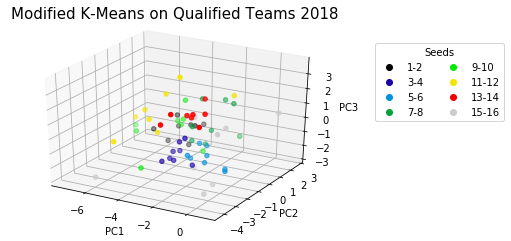

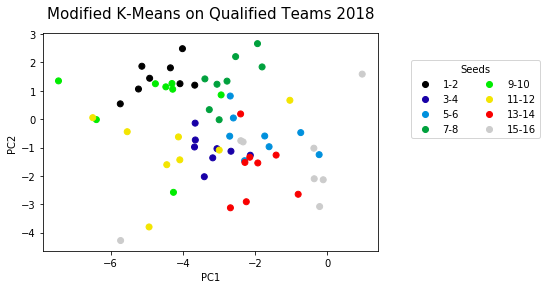

In [40]:
#8 Seeds
predicted_modified_8 =  K_means(qualified_stats_2018_all.iloc[:,2:], 8)

fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=predicted_modified_8+1,cmap='nipy_spectral')    
ax.set_title('Modified K-Means on Qualified Teams 2018',fontsize=15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
handles, labels = scatter_3D.legend_elements()
legend = plt.legend(handles,('1-2','3-4','5-6','7-8','9-10','11-12','13-14','15-16'), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

#2D-plot
fig2 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=predicted_modified_8+1,cmap='nipy_spectral')    
plt.title('Modified K-Means on Qualified Teams 2018',fontsize=15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
handles, labels = scatter_2D.legend_elements()
legend = plt.legend(handles,('1-2','3-4','5-6','7-8','9-10','11-12','13-14','15-16'), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


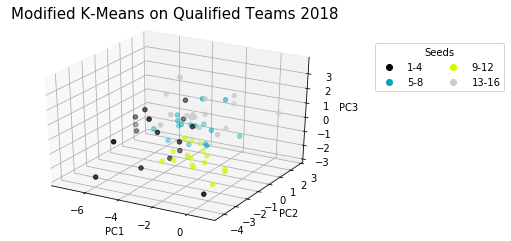

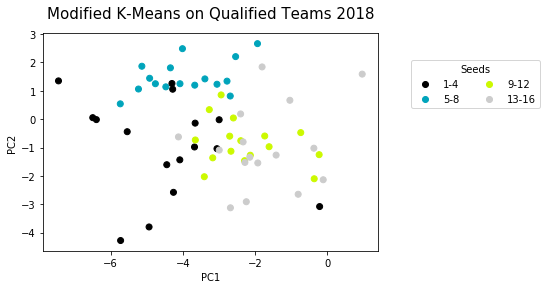

In [41]:
#4 Seeds
predicted_modified_4 =  K_means(qualified_stats_2018_all.iloc[:,2:], 4)

fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
scatter_3D = ax.scatter(pc1,pc2,pc3,c=predicted_modified_4+1,cmap='nipy_spectral')    
ax.set_title('Modified K-Means on Qualified Teams 2018',fontsize=15,pad=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
handles, labels = scatter_3D.legend_elements()
legend = plt.legend(handles,('1-4','5-8','9-12','13-16'), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

#2D-plot
fig2 = plt.figure()
scatter_2D = plt.scatter(pc1,pc2,c=predicted_modified_4+1,cmap='nipy_spectral')    
plt.title('Modified K-Means on Qualified Teams 2018',fontsize=15,pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
handles, labels = scatter_2D.legend_elements()
legend = plt.legend(handles,('1-4','5-8','9-12','13-16'), title="Seeds",bbox_to_anchor=(1.5,0.9),ncol=2)

## Clustering Evaluation (External Measures)

In [23]:
from sklearn import metrics

### Purity

In [42]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [55]:
#16 Clusters (Ground Truth vs. Regular and Modified K-Means)
ground_truth_16 = np.arange(16*4)//4
kmeans = KMeans(n_clusters=16,n_init=100)

purity_regular_16 = 0
purity_modified_16 = 0

#Average of 10 iterations of each method
for i in range(10):
    predicted_regular_16 = kmeans.fit_predict(qualified_stats_2018_all.iloc[:,2:])
    predicted_modified_16 =  K_means(qualified_stats_2018_all.iloc[:,2:], 16)
    
    purity_regular_16 += purity_score(ground_truth_16,predicted_regular_16)/10
    purity_modified_16 += purity_score(ground_truth_16,predicted_modified_16)/10
    
print('The average purity for regular K-Means algorithm with 16 clusters is {}'.format(purity_regular_16))
print('The average purity for modified K-Means algorithm with 16 clusters is {}'.format(purity_modified_16))

C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alej

The average purity for regular K-Means algorithm with 16 clusters is 0.4
The average purity for modified K-Means algorithm with 16 clusters is 0.4124999999999999


C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


In [58]:
#8 Clusters (Ground Truth vs. Regular and Modified K-Means)
ground_truth_8 = np.arange(8*8) // 8
kmeans = KMeans(n_clusters=8,n_init=100)

purity_regular_8 = 0
purity_modified_8 = 0

#Average of 10 iterations of each method
for i in range(10):
    predicted_regular_8 = kmeans.fit_predict(qualified_stats_2018_all.iloc[:,2:])
    predicted_modified_8 =  K_means(qualified_stats_2018_all.iloc[:,2:], 8)
    
    purity_regular_8 += purity_score(ground_truth_8,predicted_regular_8)/10
    purity_modified_8 += purity_score(ground_truth_8,predicted_modified_8)/10
    
print('The average purity for regular K-Means algorithm with 8 clusters is {}'.format(purity_regular_8))
print('The average purity for modified K-Means algorithm with 8 clusters is {}'.format(purity_modified_8))

C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alej

The average purity for regular K-Means algorithm with 8 clusters is 0.5
The average purity for modified K-Means algorithm with 8 clusters is 0.45


In [59]:
#4 Clusters (Ground Truth vs. Regular and Modified K-Means)
ground_truth_4 = np.arange(4*16) // 16
kmeans = KMeans(n_clusters=4,n_init=100)

purity_regular_4 = 0
purity_modified_4 = 0

#Average of 10 iterations of each method
for i in range(10):
    predicted_regular_4 = kmeans.fit_predict(qualified_stats_2018_all.iloc[:,2:])
    predicted_modified_4 =  K_means(qualified_stats_2018_all.iloc[:,2:], 4)
    
    purity_regular_4 += purity_score(ground_truth_4,predicted_regular_4)/10
    purity_modified_4 += purity_score(ground_truth_4,predicted_modified_4)/10
    
print('The average purity for regular K-Means algorithm with 4 clusters is {}'.format(purity_regular_4))
print('The average purity for modified K-Means algorithm with 4 clusters is {}'.format(purity_modified_4))

C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


The average purity for regular K-Means algorithm with 4 clusters is 0.5546875
The average purity for modified K-Means algorithm with 4 clusters is 0.5703125


C:\Users\Alejandro\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
